# Classificando nomes com uma *Character-Level RNN*

Esse notebook foi criado com base no tutorial do PyTorch: <br> 
https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb

### Problema: Dado um nome próprio de entrada, classificar esse nome de acordo com a nacionalidade a que ele pertence.

Entrada: **Hinton**

(-0.47) Scottish

(-1.52) English

(-3.57) Irish


-

Entrada: **Schmidhuber**

(-0.19) German

(-2.48) Czech

(-2.68) Dutch

### Import de bibliotecas

In [1]:
# Importa utilitários para normalização/remoção de acentos e manipulação de caracteres Unicode.
import unicodedata

# Importa constantes e funções úteis para strings (pontuação, etc.).
import string

# Importa módulos de sistema, gerador aleatório e utilidades do sistema operacional.
import sys, random, os


# Importa o PyTorch para tensores e modelos.
import torch

# Do PyTorch, traz o submódulo nn (camadas, losses, etc.).
from torch import nn

# Importa o NumPy para operações numéricas com arrays.
import numpy as np

# Importa o Seaborn para melhorar a estética dos gráficos.
import seaborn as sns

# Define o estilo visual padrão dos gráficos do Seaborn.
sns.set_style('darkgrid')

# Importa o Matplotlib para plotagem.
import matplotlib.pyplot as plt

# (Jupyter) Faz com que os gráficos sejam renderizados inline nas células.
%matplotlib inline


In [2]:
# Cria um dicionário para hiperparâmetros e configs de treino/inferência.
args = {
# Taxa de aprendizado (learning rate) — aqui, 5×10⁻⁵.
    'lr': 5e-5,
# Fator de regularização L2 (weight decay) para evitar overfitting.
    'regularizacao': 1e-7,
# Número total de épocas de treinamento.
    'num_epocas': 40,
# Fecha o dicionário.
}

# (Opcional) Seleção automática do dispositivo: CUDA se disponível, senão CPU.
# args['device'] = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Força o uso de CPU explicitamente (string 'cpu' também é aceita por torch.Tensor.to()).
args['device'] = 'cpu'


## Dados de entrada

### Importando dataset

In [3]:
# comente as duas linhas seguintes caso rode mais de uma vez
# !wget https://download.pytorch.org/tutorial/data.zip #
# !unzip data.zip #
############################################################

In [4]:
# Define uma função que lê um arquivo de nomes e retorna listas de nomes e rótulos.
# Transforma um arquivo de nomes em listas e/ou arrays (nomes, rotulos)
def readLines(filename):
    # Lê o arquivo inteiro, remove espaços em branco nas extremidades e separa por quebras de linha.
    lines     = open(filename).read().strip().split('\n')
    # Normaliza Unicode para ASCII (remove acentos); ATENÇÃO: o resultado aqui vira bytes (b'...').
    nomes     = [unicodedata.normalize('NFKD', line).encode('ascii', 'ignore') for line in lines]
    # Extrai a categoria a partir do nome do arquivo (ex.: 'Portuguese' de '.../Portuguese.txt').
    categoria = filename.split('/')[-1].split('.')[0]
    # Cria um vetor de rótulos repetindo a categoria para cada nome do arquivo.
    rotulos   = np.repeat( categoria, len(nomes) )

    # Retorna a lista de nomes normalizados e seus rótulos correspondentes.
    return nomes, rotulos 


# Define o diretório onde estão os arquivos de nomes por idioma/categoria.
root_path = 'data/names/'
# Lista todos os arquivos do diretório, em ordem alfabética.
arquivos = sorted(os.listdir(root_path))
# Obtém a lista de categorias removendo a extensão '.txt' de cada arquivo.
categorias = [a[:-4] for a in arquivos]

# Inicializa contêineres para dados (nomes), rótulos e estatísticas por classe.
dados, rotulos = [], []
samples_perclass = []

# Itera por cada arquivo de nomes disponível.
for file_name in arquivos:
  # Lê nomes e rótulos do arquivo atual.
  retorno = readLines(os.path.join(root_path,file_name))
  # Empilha a lista de nomes (bytes) na lista global 'dados'.
  dados.append(retorno[0])
  # Empilha o vetor de rótulos correspondente na lista global 'rotulos'.
  rotulos.append(retorno[1])

  # Armazena uma tupla (nome_do_arquivo, quantidade_de_nomes) para análise posterior.
  samples_perclass.append( (file_name, len(retorno[0])) )


# Imprime a contagem de amostras por arquivo/categoria.
print(samples_perclass, )
# Imprime qual categoria tem o menor número de amostras.
print('Minimo amostras', min(samples_perclass, key= lambda k: k[1]), '\n' )

# Mostra os 10 primeiros nomes (em bytes) da categoria 'Portuguese'.
print(dados[categorias.index('Portuguese')][0:10])
# Mostra os 10 rótulos correspondentes a esses nomes.
print(rotulos[categorias.index('Portuguese')][0:10])


[('Arabic.txt', 2000), ('Chinese.txt', 268), ('Czech.txt', 519), ('Dutch.txt', 297), ('English.txt', 3668), ('French.txt', 277), ('German.txt', 724), ('Greek.txt', 203), ('Irish.txt', 232), ('Italian.txt', 709), ('Japanese.txt', 991), ('Korean.txt', 94), ('Polish.txt', 139), ('Portuguese.txt', 74), ('Russian.txt', 9408), ('Scottish.txt', 100), ('Spanish.txt', 298), ('Vietnamese.txt', 73)]
Minimo amostras ('Vietnamese.txt', 73) 

[b'Abreu', b'Albuquerque', b'Almeida', b'Alves', b'Araujo', b'Araullo', b'Barros', b'Basurto', b'Belo', b'Cabral']
['Portuguese' 'Portuguese' 'Portuguese' 'Portuguese' 'Portuguese'
 'Portuguese' 'Portuguese' 'Portuguese' 'Portuguese' 'Portuguese']


### Convertendo os dados para tensor

**Convertendo os rótulos para tensor**

Representação One-Hot de 18 categorias de idiomas que queremos prever.

In [5]:
# Define uma função que converte um vetor de rótulos (strings) para um tensor de índices inteiros (shape N×1).
def label2tensor(rotulos):
  # Cria um tensor de zeros com N linhas e 1 coluna (tipo inteiro 64 bits) para armazenar os índices das classes.
  rotulos_tns = torch.zeros( len(rotulos), 1, dtype=torch.int64 )
  # Percorre cada rótulo e sua posição k.
  for k, rotulo in enumerate(rotulos):
    # Encontra o índice da classe na lista global 'categorias' (ex.: 'Portuguese' → índice correspondente).
    idx = categorias.index(rotulo)
    # Grava o índice encontrado na linha k (coluna 0) do tensor de rótulos.
    rotulos_tns[k][0] = idx
  # Retorna o tensor N×1 com os índices das classes.
  return rotulos_tns

# Seleciona o vetor de rótulos da primeira categoria listada (por exemplo, 'Arabic'), conforme a ordem em 'arquivos'.
rotulos_arabe = rotulos[0]
# Converte esse vetor de rótulos de strings para um tensor de índices inteiros.
rotulos_tns = label2tensor(rotulos_arabe)
# Imprime o tipo do tensor resultante, o primeiro rótulo original e o índice correspondente no tensor.
print(type(rotulos_tns), rotulos_arabe[0], rotulos_tns[0])


<class 'torch.Tensor'> Arabic tensor([0])


**Convertendo os nomes para tensor**

Aqui também usaremos a representação One-Hot, porém teremos que trabalhar com uma lista de tensores, pois os nomes tem comprimentos diferentes. Mais à frente no curso aprenderemos a lidar com isso da forma certa!

In [6]:
# Define os caracteres válidos (apenas letras ASCII minúsculas e maiúsculas).
caracteres_validos = string.ascii_letters + " '-"

# Mostra o conjunto de caracteres válido (útil para checagem).
print(caracteres_validos)

# Tamanho do “vocabulário” de caracteres (número de colunas do one-hot).
tam_dicionario = len(caracteres_validos)

# Converte um nome (em bytes) para uma matriz one-hot de shape (len(nome), tam_dicionario).
def nome2tensor(nome):
    # Decodifica de bytes para string UTF-8 (ex.: b'José' → 'José').
    nome = nome.decode('utf-8')
    # Inicializa o tensor de zeros (uma linha por caractere, uma coluna por símbolo do vocabulário).
    tns = torch.zeros(len(nome), tam_dicionario, dtype=torch.float32)
    # Percorre cada caractere do nome e sua posição k.
    for k, letra in enumerate(nome):
        # Busca o índice da letra no vocabulário; se não existir, retorna -1.
        idx = caracteres_validos.find(letra)
        # Só marca 1.0 se a letra for conhecida (idx >= 0); evita escrever na coluna -1 por engano.
        if idx >= 0:                 # << evita o índice -1
            tns[k, idx] = 1.0
        # Caso contrário, mantém a linha toda zero (caractere ignorado).
        # else: linha fica toda zero (caractere ignorado)
    # Retorna a matriz one-hot correspondente ao nome.
    return tns

# Seleciona a lista de nomes da primeira categoria (ex.: 'Arabic'), conforme a ordem em `arquivos`.
dados_arabe = dados[0]

# Converte cada nome dessa lista para seu tensor one-hot correspondente.
dados_tns = [nome2tensor(dado) for dado in dados_arabe]

# Imprime o primeiro caractere (já decodificado) e o vetor one-hot da primeira posição do primeiro nome.
print(dados_arabe[0].decode('utf-8')[0],'\n', dados_tns[0][0])


abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ '-
K 
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])


**Amostrando batch balanceado**

In [7]:
# Define o nº de amostras por classe como o mínimo entre as categorias (balanceamento por downsampling).
num_amostras = min(samples_perclass, key= lambda k: k[1])[1]

# Função que amostra, para cada categoria, 'size' nomes e retorna tensores dos nomes e rótulos.
def sample_batch(size=num_amostras):
  # Acumuladores de nomes (bytes) e rótulos (strings) do mini-conjunto balanceado.
  dados_batch, rotulos_batch = [], []
  # Percorre cada categoria disponível.
  for cat in categorias:
    
    # Recupera a lista de nomes da categoria atual.
    amostras_cat = dados[categorias.index(cat)]
    # Escolhe 'size' índices aleatórios dessa categoria (por padrão, com reposição; use replace=False para sem reposição).
    idx = np.random.choice(range(len(amostras_cat)), size=size)

    # Coleta os nomes correspondentes aos índices sorteados e acumula.
    dados_batch.extend([ r for k, r in enumerate(dados[categorias.index(cat)]) if k in idx])
    # Coleta os rótulos correspondentes aos mesmos índices e acumula.
    rotulos_batch.extend([ r for k, r in enumerate(rotulos[categorias.index(cat)]) if k in idx])

  # Converte cada nome (bytes) para tensor one-hot (len(nome) × tam_dicionario).
  dados_tns = [nome2tensor(dado) for dado in dados_batch]
  # Converte os rótulos (strings) para tensor de índices (N × 1).
  return dados_tns, label2tensor(rotulos_batch)

# Gera um lote balanceado (mesmo nº por classe) e imprime algumas informações.
dados_batch, rotulos_batch = sample_batch()
print(len(dados_batch), dados_batch[0].size(), rotulos_batch.size())


1111 torch.Size([5, 55]) torch.Size([1111, 1])


### Por fim, vamos separar dados de treino e teste.

In [8]:
# Importa a função utilitária para dividir dados em treino e teste.
from sklearn.model_selection import train_test_split

# Divide os dados em conjuntos de treino e teste (80/20) com semente fixa para reprodutibilidade.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(
    # Conjunto de entradas (lista de tensores one-hot por nome).
    dados_tns,
    # Conjunto de rótulos correspondentes (tensor N×1 com índices de classe).
    rotulos_tns,
    # Proporção destinada ao conjunto de teste: 20%.
    test_size=0.2,
    # Semente para tornar o split determinístico.
    random_state=42
)


## Modelo Recorrente

* Implemente um modelo para classificação de nomes próprios (série de caracteres) usando apenas camadas *RNNCell*, *Linear* e ativação *LogSoftmax*
* Cada entrada (caracter) possui dimensão (52): alfabeto maiúsculo e minúsculo
* *Hidden size* possui dimensão (256): hiperparâmetro 
* Saída possui dimensão (18): vetor de probabilidade de classes
* Batch size = 1 **pra não termos que lidar com as sequências de tamanho variável.**

### Links úteis

RNNCell: https://pytorch.org/docs/stable/generated/torch.nn.RNNCell.html#torch.nn.RNNCell

Linear: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear

Non-linear activations: https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html#torch.nn.LogSoftmax

In [9]:
# Define uma classe de rede recorrente simples (RNN) para classificação de nomes por categoria.
class RNN(nn.Module):
    # Construtor: recebe tamanhos de entrada (nº de caracteres), de estado oculto (features) e de saída (nº de classes).
    def __init__(self, tam_entrada, tam_feature, tam_saida):
        # Inicializa a superclasse nn.Module.
        super(RNN, self).__init__()
        
        # Armazena os hiperparâmetros como atributos do objeto.
        self.tam_entrada = tam_entrada
        self.tam_feature = tam_feature
        self.tam_saida   = tam_saida
        
        # Define uma célula RNN (um passo temporal por vez): entrada → estado oculto.
        self.rnn    = nn.RNNCell(self.tam_entrada, self.tam_feature)
        # Camada linear final que mapeia o estado oculto para logits de classes.
        self.linear = nn.Linear(self.tam_feature, self.tam_saida)
        # LogSoftmax para produzir log-probabilidades; (em versões recentes, especifique dim=1).
        self.softmax = nn.LogSoftmax(dim=1)  # usa a dimensão das classes
    
    # Define o fluxo direto: recebe um nome como sequência de vetores one-hot (T × tam_entrada).
    def forward(self, nome):
      
        # Inicializa o estado oculto com zeros (batch=1) no dispositivo configurado.
        hidden = torch.zeros(1, self.tam_feature).to(args['device'])
        
        # Itera caractere a caractere (cada 'letra' é um vetor one-hot de tamanho tam_entrada).
        for letra in nome:
          # Adiciona dimensão de batch (1 × tam_entrada) para combinar com a RNNCell.
          letra = letra.unsqueeze(0)
          # Atualiza o estado oculto com a célula RNN.
          hidden = self.rnn(letra, hidden)
        
        # Projeta o estado oculto para o espaço de classes (logits).
        saida = self.linear(hidden)
        # Converte logits em log-probabilidades (mais estável numericamente).
        saida = self.softmax(saida) 
        # Retorna o tensor (1 × tam_saida) com log-probs por classe.
        return saida

# Define o tamanho do estado oculto (nº de features na RNN).
tam_feature = 256
# Instancia o modelo: entrada = tamanho do dicionário de caracteres, saída = nº de categorias.
model = RNN(tam_dicionario, tam_feature, len(categorias))
# Move o modelo para o dispositivo definido (CPU/GPU).
model.to(args['device'])


RNN(
  (rnn): RNNCell(55, 256)
  (linear): Linear(in_features=256, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)

## Loss e Otimizador

In [10]:
# Define a função de perda NLL (compatível com saídas em log-probabilidade do LogSoftmax) e move para o device.
criterion = nn.NLLLoss().to(args['device']) 

# Cria o otimizador Adam para os parâmetros do modelo, com taxa de aprendizado e regularização L2 definidas em args.
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['regularizacao'])


## Treinamento

A otimização é um processo que tem uma raíz muito bem definida de passo a passo, sempre fazemos:
* Carregar os dados e colocar no dispositivo de hardware adequado
* Forward do dado na rede
* Cálculo da função de custo (no nosso caso uma função composta)
* Passos de Otimização
  * Zerar os gradientes do otimizador (`optimizer.zero_grad()`)
  * Calcular os gradientes com base na loss (`loss.backward()`)
  * Passo de otimização (`optimizer.step()`)

Apesar de cada solução ter pequenas variações em um ou mais passos do fluxo, o esqueleto é sempre o mesmo. 

In [11]:
# Define uma passada (época) sobre uma sequência de pares (X, Y), alternando treino/validação pelo argumento `etapa`.
def forward(X, Y, etapa):
  # Se for treino, ativa modo de treinamento (Dropout/BN em training); caso contrário, eval().
  if etapa == 'Treino': model.train()
  else: model.eval()

  # Inicializa a acurácia acumulada (contagem de acertos).
  acuracia = 0.
  # Lista para armazenar as perdas (uma por amostra).
  loss_epoca = []
  # Itera sobre os dados e rótulos (um a um), com índice k (não usado adiante).
  for k, (dado, rotulo) in enumerate(zip(X, Y)):
      
    # Move a amostra para o dispositivo (CPU/GPU) configurado.
    dado = dado.to(args['device'])
    # Move o rótulo correspondente para o mesmo dispositivo.
    rotulo = rotulo.to(args['device'])

    # Forward pass: obtém a saída do modelo (log-probabilidades no seu setup).
    saida = model(dado)
    # Calcula a perda da amostra segundo o critério definido (NLLLoss).
    loss = criterion(saida, rotulo)
    # Guarda a perda como valor escalar (nota: .item() também funcionaria).
    loss_epoca.append(loss.detach().cpu().numpy())

    # Obtém a classe predita (argmax sobre a dimensão de classes).
    _, pred = torch.max(saida, axis=-1)
    # Incrementa acurácia se a predição (pred[0]) for igual ao rótulo verdadeiro (rotulo[0]).
    acuracia += 1 if pred[0].item() == rotulo[0].item() else 0

    # Se estiver em etapa de treino, faz backprop e atualiza parâmetros.
    if etapa == 'Treino':
      # Zera gradientes acumulados do passo anterior.
      # Otimização
      optimizer.zero_grad()
      # Backpropaga o erro.
      loss.backward()
      # Aplica a atualização de pesos do otimizador.
      optimizer.step()

  # Converte a lista de perdas para array NumPy e achata (por segurança).
  loss_epoca = np.asarray(loss_epoca).ravel()
  # Converte acertos absolutos em fração de acertos (acurácia em [0,1]).
  acuracia   = acuracia/float(len(loss_epoca))
  # Log amigável da etapa atual (OBS: usa variável externa `epoca`; certifique-se de defini-la).
  print('\n','*'*15 + etapa + '*'*15 )
  # Imprime média e desvio da loss, além da acurácia; `epoca` deve existir no escopo global.
  print('Epoca: {:}, Loss: {:.4f} +/- {:.4f}, Acurácia: {:.4f}'.format(epoca, loss_epoca.mean(), 
                                                                        loss_epoca.std(), 
                                                                        acuracia
                                                                       )) 
  # Retorna a perda média e a acurácia desta passada.
  return loss_epoca.mean(), acuracia


In [12]:
# Listas para registrar a perda média por época (treino e teste).
loss_treino, loss_test = [], []

# Listas para registrar a acurácia por época (treino e teste).
acc_treino, acc_test = [], []

# Amostra um conjunto fixo de teste (pequeno) para avaliar a cada época.
dados_test, rotulos_test = sample_batch(size=5)

# Loop de treinamento por 200 épocas (variável 'epoca' também é usada em forward()).
for epoca in range(1000):

  # A cada época, amostra um lote balanceado de treinamento (todas as classes).
  dados_tns, rotulos_tns = sample_batch()

  # Executa uma passada de TREINO: retorna loss média da época e acurácia.
  loss, acuracia = forward(dados_tns, rotulos_tns, 'Treino')

  # Armazena a loss de treino desta época para plot/monitoramento.
  loss_treino.append(loss)

  # Armazena a acurácia de treino desta época.
  acc_treino.append(acuracia)  

  # Executa uma passada de TESTE no conjunto fixo (sem atualizar pesos).
  loss, acuracia = forward(dados_test, rotulos_test, 'Teste')

  # Armazena a loss de teste desta época.
  loss_test.append(loss)

  # Armazena a acurácia de teste desta época.
  acc_test.append(acuracia)



 ***************Treino***************
Epoca: 0, Loss: 2.6262 +/- 0.7390, Acurácia: 0.1652

 ***************Teste***************
Epoca: 0, Loss: 3.2147 +/- 0.8584, Acurácia: 0.0449

 ***************Treino***************
Epoca: 1, Loss: 2.5500 +/- 0.7441, Acurácia: 0.1489

 ***************Teste***************
Epoca: 1, Loss: 3.5663 +/- 1.3606, Acurácia: 0.0562

 ***************Treino***************
Epoca: 2, Loss: 2.5904 +/- 0.7092, Acurácia: 0.1121

 ***************Teste***************
Epoca: 2, Loss: 3.3845 +/- 1.0790, Acurácia: 0.0449

 ***************Treino***************
Epoca: 3, Loss: 2.4596 +/- 0.7470, Acurácia: 0.1515

 ***************Teste***************
Epoca: 3, Loss: 2.9627 +/- 0.5331, Acurácia: 0.1124

 ***************Treino***************
Epoca: 4, Loss: 2.4322 +/- 0.7258, Acurácia: 0.1813

 ***************Teste***************
Epoca: 4, Loss: 3.3537 +/- 1.1174, Acurácia: 0.0674

 ***************Treino***************
Epoca: 5, Loss: 2.4458 +/- 0.7726, Acurácia: 0.1791

 **

## Análise de Convergência

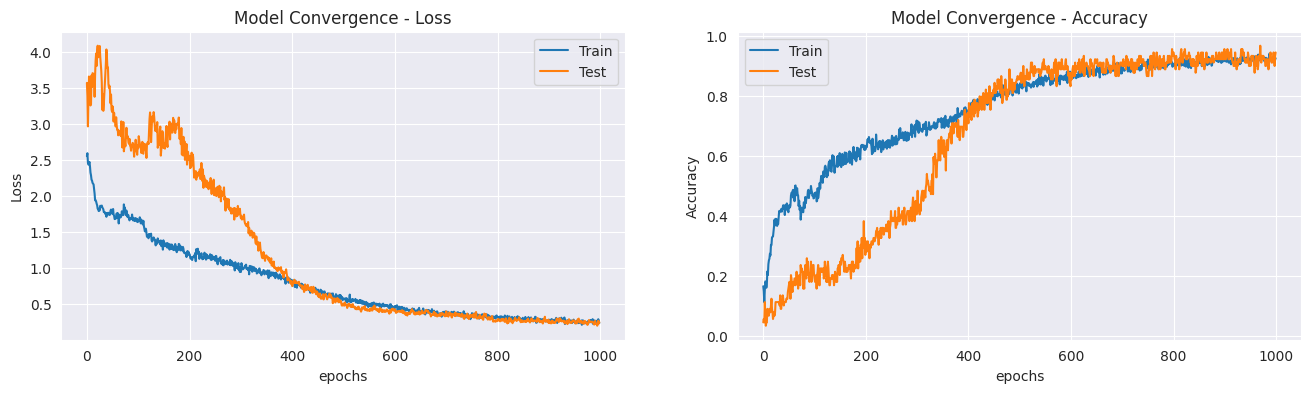

In [ ]:
# Cria uma figura com 1 linha e 2 eixos (subplots) lado a lado; tamanho total de 16×4 polegadas.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

# Plota a curva de loss de treino (ignorando o primeiro ponto) no primeiro eixo.
ax1.plot(loss_treino[1:], label='Train')
# Plota a curva de loss de teste (ignorando o primeiro ponto) no primeiro eixo.
ax1.plot(loss_test[1:], label='Test')
# Define o título do gráfico do primeiro eixo.
ax1.set_title('Model Convergence - Loss')
# Rótulo do eixo X do primeiro gráfico (épocas).
ax1.set_xlabel('epochs')
# Rótulo do eixo Y do primeiro gráfico (loss).
ax1.set_ylabel('Loss')
# Exibe a legenda para distinguir as curvas de treino e teste no primeiro eixo.
ax1.legend()

# Plota a curva de acurácia de treino no segundo eixo.
ax2.plot(acc_treino, label='Train')
# Plota a curva de acurácia de teste no segundo eixo.
ax2.plot(acc_test, label='Test')
# Define o título do gráfico do segundo eixo.
ax2.set_title('Model Convergence - Accuracy')
# Rótulo do eixo X do segundo gráfico (épocas).
ax2.set_xlabel('epochs')
# Rótulo do eixo Y do segundo gráfico (acurácia).
ax2.set_ylabel('Accuracy')
# Exibe a legenda para distinguir as curvas de treino e teste no segundo eixo.
ax2.legend()
# Mostra a figura com os dois gráficos lado a lado.
plt.show()

## Usando o modelo

In [ ]:
# Define uma função de inferência que recebe um nome (string) e imprime as 3 classes mais prováveis.
def predict(nome):
  # Coloca o modelo em modo de avaliação (desativa Dropout e usa BN com estatísticas fixas).
  model.eval()

  # Cria um tensor one-hot zerado com uma linha por caractere e uma coluna por símbolo do vocabulário.
  tns = torch.zeros( len(nome), tam_dicionario )
  # Percorre cada caractere do nome e marca a coluna correspondente no one-hot.
  for k, letra in enumerate(nome):
    # Busca o índice da letra no vocabulário; se não existir, retorna -1.
    idx = caracteres_validos.find(letra)
    # Só marca 1.0 se a letra for conhecida (idx >= 0); evita escrever na coluna -1 por engano.
    if idx >= 0:                 # << evita o índice -1
        tns[k, idx] = 1.0
    # Caso contrário, mantém a linha toda zero (caractere ignorado).
    # else: linha fica toda zero (caractere ignorado)
  # Move o tensor de entrada para o dispositivo configurado (CPU/GPU).
  tns = tns.to(args['device'])

  # Forward: obtém as pontuações (aqui, log-probabilidades se o modelo usar LogSoftmax na saída).
  saida = model(tns)
  # Seleciona o top-3 ao longo da dimensão das classes (dim=1); retorna valores e índices.
  topv, topi = saida.data.topk(3, 1, True)

  # Imprime o nome consultado.
  print(nome)
  # Itera pelos pares (valor, índice) do top-3 para exibir a classe prevista.
  # OBS: `index` é um tensor escalar; se necessário para indexação em listas, use `index.item()`.
  for value, index in zip(topv[0], topi[0]):
    # Mostra a pontuação (value) e a classe correspondente em `categorias`.
    print('(%.2f) %s' % (value, categorias[index]))
  # Linha em branco para separar chamadas.
  print('\n')

# Exemplos de uso da função de predição com três nomes.
predict('Merkel')
predict('Hirobumi')
predict('Suarez')
predict('Ow-Gao')
predict('De la mancha')
predict('Lessa')
predict('Leça')

Merkel
(-0.77) Czech
(-1.27) German
(-1.72) Dutch


Hirobumi
(-0.00) Japanese
(-8.16) Russian
(-8.96) Arabic


Suarez
(-0.02) Spanish
(-3.99) Portuguese
(-5.63) German


Ow-Gao
(-0.74) Chinese
(-0.92) Japanese
(-2.68) Vietnamese


De la mancha
(-0.02) Italian
(-4.43) Spanish
(-5.79) Czech


Lessa
(-0.23) Italian
(-1.80) Spanish
(-4.55) Czech


Leça
(-1.01) Italian
(-1.73) Portuguese
(-1.80) Spanish




In [ ]:
# Salvando o modelo treinado em disco
torch.save(model.state_dict(), 'rnn_name_classifier.pth')